#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [1]:
!pip install numpy pandas scikit-learn wandb

In [2]:
import wandb
wandb.login(key="a6a94b6d818d2782081ecf253d9a0eae685ddf8d")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vansh-kohli-ug23 (vansh-kohli-ug23-plaksha-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
## import cv2
import cv2
## import numpy
import numpy as np
## import matplotlib pyplot
import matplotlib.pyplot as plt
## import KMeans cluster from sklearn
from sklearn.cluster import KMeans
## import distance from scipy.spatial
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import accuracy_score, log_loss, silhouette_score

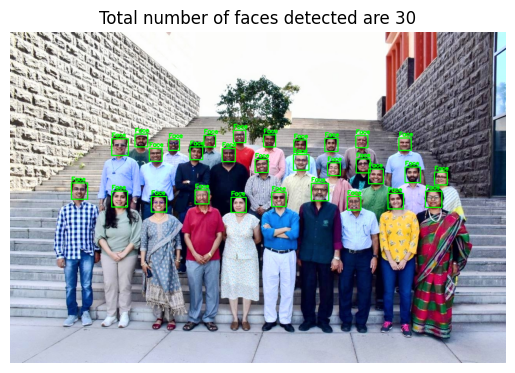

In [4]:
## Reading the image plaksha_Faculty.jpg
img = cv2.imread('/kaggle/input/plaksha/Plaksha_Faculty.jpg')
rgb_pf = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
## Convert the image to grayscale
gray_img = cv2.cvtColor(rgb_pf, cv2.COLOR_RGB2GRAY)
  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = "Face" ## The text you want to write
font = cv2.FONT_HERSHEY_SIMPLEX ## Font type
font_scale = 0.5 ## Font scale factor
font_color = (0, 255, 0)  ## Text color in BGR format (here, it's red)
font_thickness = 2  ## Thickness of the text

  
# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(rgb_pf, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(rgb_pf, text, (x, y - 5), font, font_scale, font_color, font_thickness)
    
## Display the image and window title should be "Total number of face detected are #"  
plt.imshow(rgb_pf)
plt.title(f"Total number of faces detected are {len(faces_rect)}")
plt.axis("off")
plt.savefig("detected_faces_img.png")
plt.show()

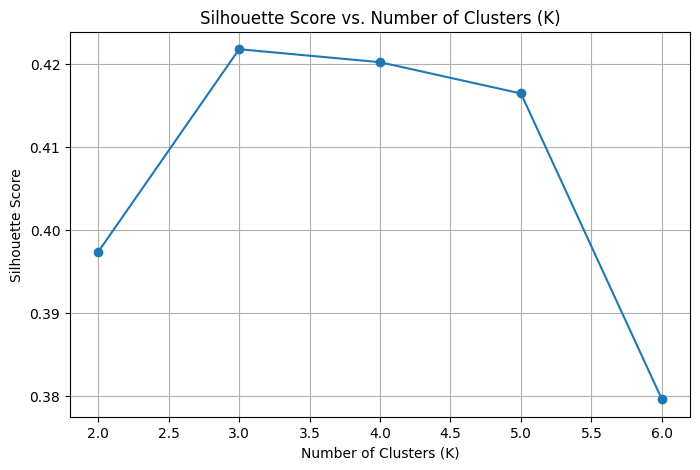

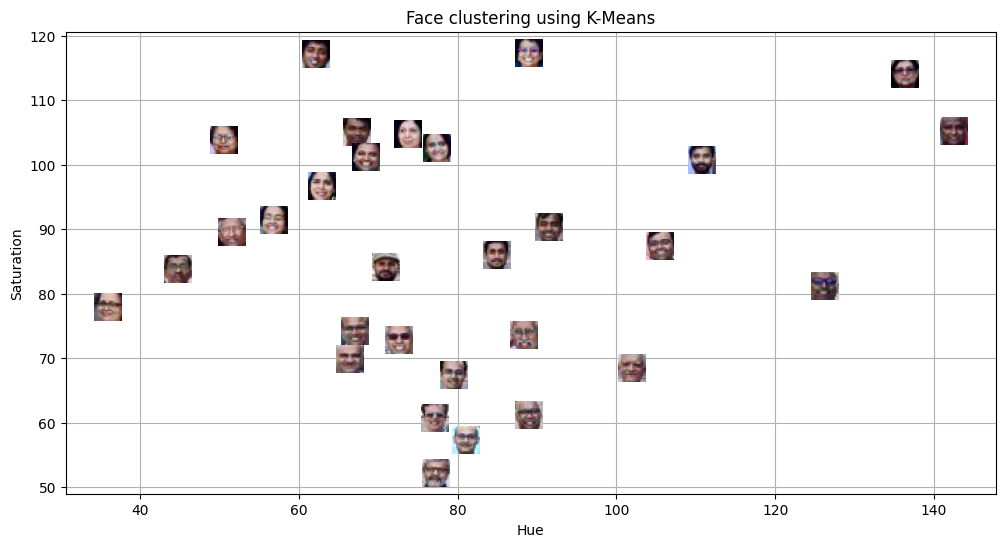

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) ## call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)
wandb.init(project="distance_classification_project", name="KMeans_Clustering")
silhouette_scores = {}
## Perform k-Means clustering on hue_saturation and store in kmeans
for k in range(2, 7):  # Try K values from 2 to 6
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=30).fit(hue_saturation)
    silhouette = silhouette_score(hue_saturation, kmeans.labels_)
    silhouette_scores[k] = silhouette
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters (K)")
plt.grid(True)
plt.savefig("silhouette_scores.png")
wandb.log({"Silhouette Score Plot": wandb.Image("silhouette_scores.png")})
plt.show()

# centroids = kmeans.cluster_centers_
# labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

kmeans = KMeans(n_clusters = 2, random_state = 45, n_init = 30).fit(hue_saturation)
# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])

## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Face clustering using K-Means")
## Put grid
plt.grid()
## show the plot
plt.savefig("face_clustering_plt.png")
wandb.log({"Face clustering using K-means": wandb.Image("face_clustering_plt.png")})
plt.show()

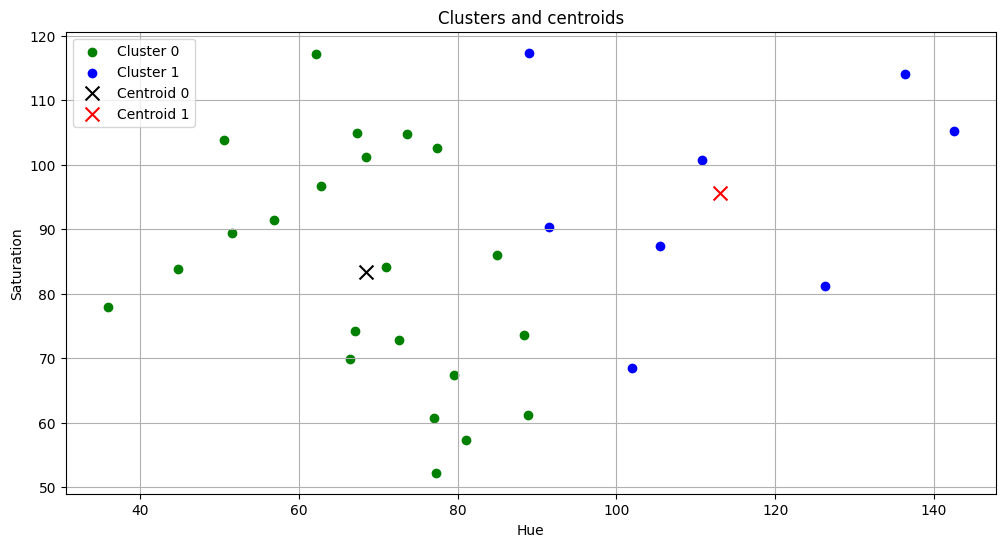

In [6]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color = 'green', label = 'Cluster 0')


cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color = 'blue', label = 'Cluster 1')

# Calculate and plot centroids
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], color = 'black', marker = 'x', s = 100, label = 'Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], color = 'red', marker = 'x', s = 100, label = 'Centroid 1')
## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Clusters and centroids")
## Add a legend
plt.legend()
## Add grid
plt.grid()
## Show the plot
plt.savefig("clusters and centroids.png")
wandb.log({"Cluster Visualization": wandb.Image("clusters and centroids.png")})
plt.show()

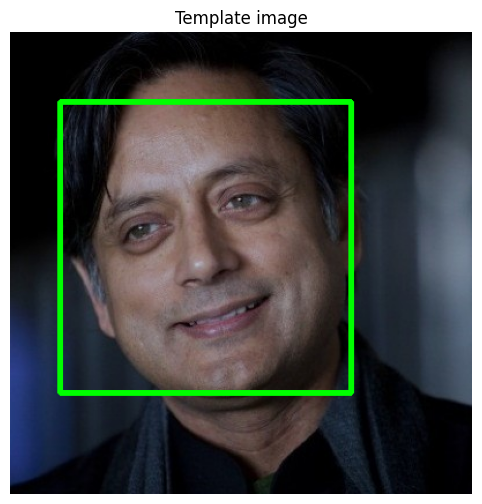

In [7]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread('/kaggle/input/plaksha/Dr_Shashi_Tharoor.jpg')
# Detect face  in the template image after converting it to gray and store it in template_faces
rgb_temp = cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB)
gray_temp = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)

template_faces = face_cascade.detectMultiScale(gray_temp, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(rgb_temp, (x, y), (x + w, y + h), (0, 255, 0), 3)
plt.figure(figsize = (8, 6))
plt.imshow(rgb_temp)
plt.title("Template image")
plt.axis("off")
plt.savefig("template image.png")
plt.show()    

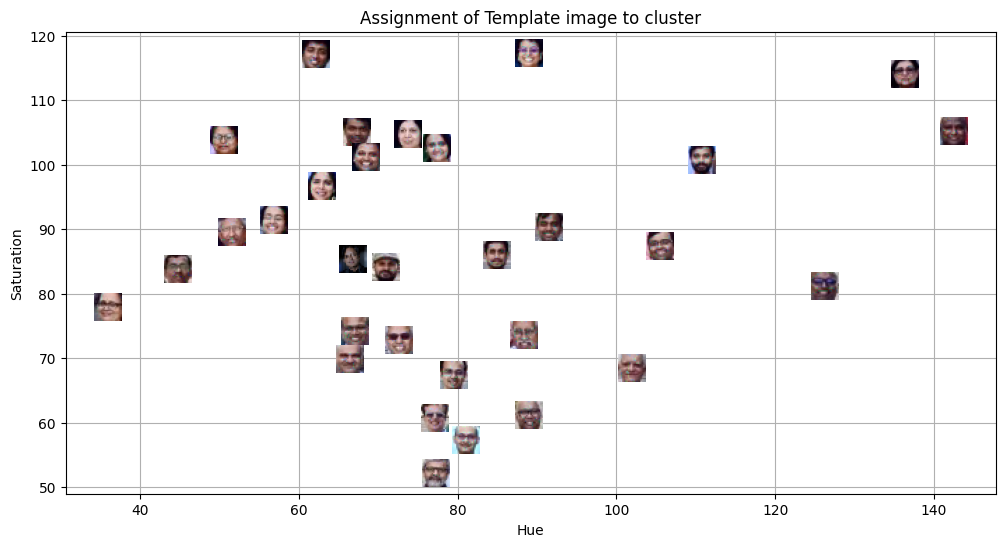

In [8]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Assignment of Template image to cluster")
## Add grid
plt.grid()
## show plot
plt.savefig("Assignment of Template image to cluster.png")
wandb.log({"Face clustering using K-means with template image": wandb.Image("Assignment of Template image to cluster.png")})
plt.show()

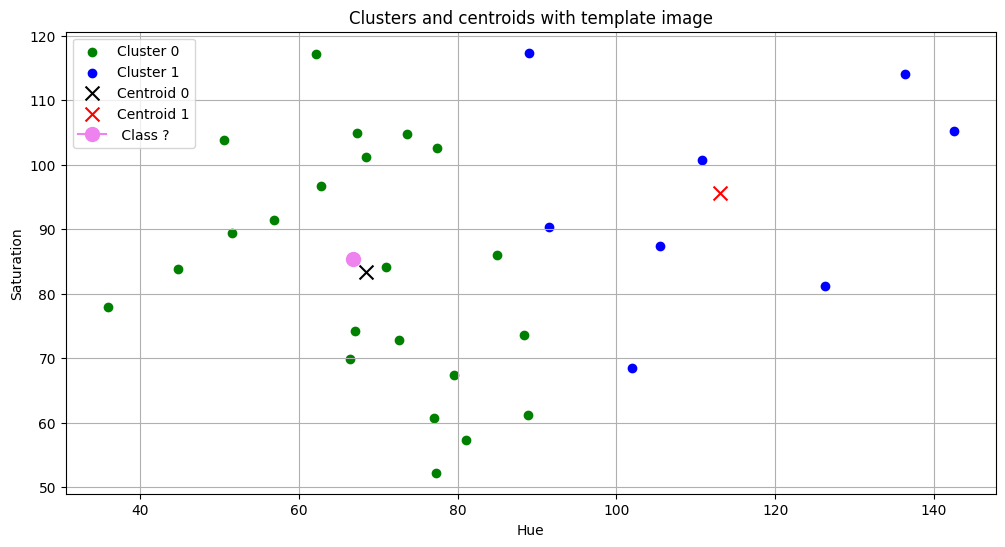

In [9]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color = 'green', label = 'Cluster 0')

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color = 'blue', label = 'Cluster 1')

# Calculate and plot centroids
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]


plt.scatter(centroid_0[0], centroid_0[1], color = 'black', marker = 'x', s = 100, label = 'Centroid 0') ## plot for centroid 0
plt.scatter(centroid_1[0], centroid_1[1], color = 'red', marker = 'x', s = 100, label = 'Centroid 1')  ## plot for centroid 1
plt.plot(template_hue, template_saturation, marker='o', c= 'violet',markersize= 10, label=' Class ?' )
## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Clusters and centroids with template image")
## Add a legend
plt.legend()
## Add grid
plt.grid()
## Show the plot
plt.savefig("clusters and centroids wtih template image.png")
wandb.log({"Cluster visualization": wandb.Image("clusters and centroids wtih template image.png")})
plt.show()
                                            ## End of the lab 5 ##

## Report:
## Answer the following questions within your report:


#### 1. What are the common distance metrics used in distance-based classification algorithms? 

1. Euclidean Distance: Measures the straight-line distance between two vectors.  
2. Manhattan Distance: Calculates the distance between two points by summing the absolute differences along perpendicular axes.  
3. Mahalanobis Distance: Determines how far a point P is from a distribution D in terms of standard deviations from the mean of D.

#### 2. What are some real-world applications of distance-based classification algorithms? 

1. Medical Diagnosis through Disease Classification: Algorithms like KNN can be used to categoriSe patient conditions based on symptoms or lab test results.  
2. Object Detection & Face Recognition: In computer vision, distance-based methods help identify and classify images or specific regions based on visual characteristics.  
3. Spam Detection: By transforming text into feature vectors, these algorithms can distinguish between spam and non-spam emails or documents.

#### 3. Explain various distance metrics. 

1. Euclidean Distance: Measures the shortest straight-line distance between two vectors.  
2. Chebyshev Distance: Defined in a vector space, it represents the maximum absolute difference between corresponding coordinates of two vectors. Formula: max(|xa - xb|,|ya - yb|). 
3. Minkowski Distance: A flexible distance metric that can be adjusted by varying the parameter 'p' to compute the distance between two points. Formula:(sum i = 1 to n (|xi - yi|^p))^1/p.

#### 4. What is the role of cross validation in model performance? 

Role of Cross-Validation in Model Performance:
1. Minimising Overfitting: By evaluating the model on multiple data splits, cross-validation ensures that performance is not biased by a specific train-test division.  
2. Optimising Hyper parameters: It aids in selecting the best hyper parameters (e.g., the value of k in KNN) by assessing model performance across various configurations.  
3. Choosing the Best Model: Cross-validation provides a consistent evaluation framework for comparing different models, helping to identify the most generalisable one.

#### 5. Explain variance and bias in terms of KNN? 

1. Bias: Refers to the tendency of a model to lean toward a particular outcome. A high bias indicates that the model is overly simplistic and may under fit the data.  
Example: When k is too large in KNN, the model averages over many neighbours, creating an overly smooth decision boundary. This high bias may cause the model to overlook important local patterns.  

2. Variance: Represents the extent to which a model’s predictions fluctuate for a given data point. A high variance suggests the model is highly sensitive to training data variations, increasing the risk of overfitting.  
Example: When k is too small in KNN, the model becomes highly responsive to noise in the training data. This leads to high variance, where even slight changes in the dataset significantly impact the decision boundary.